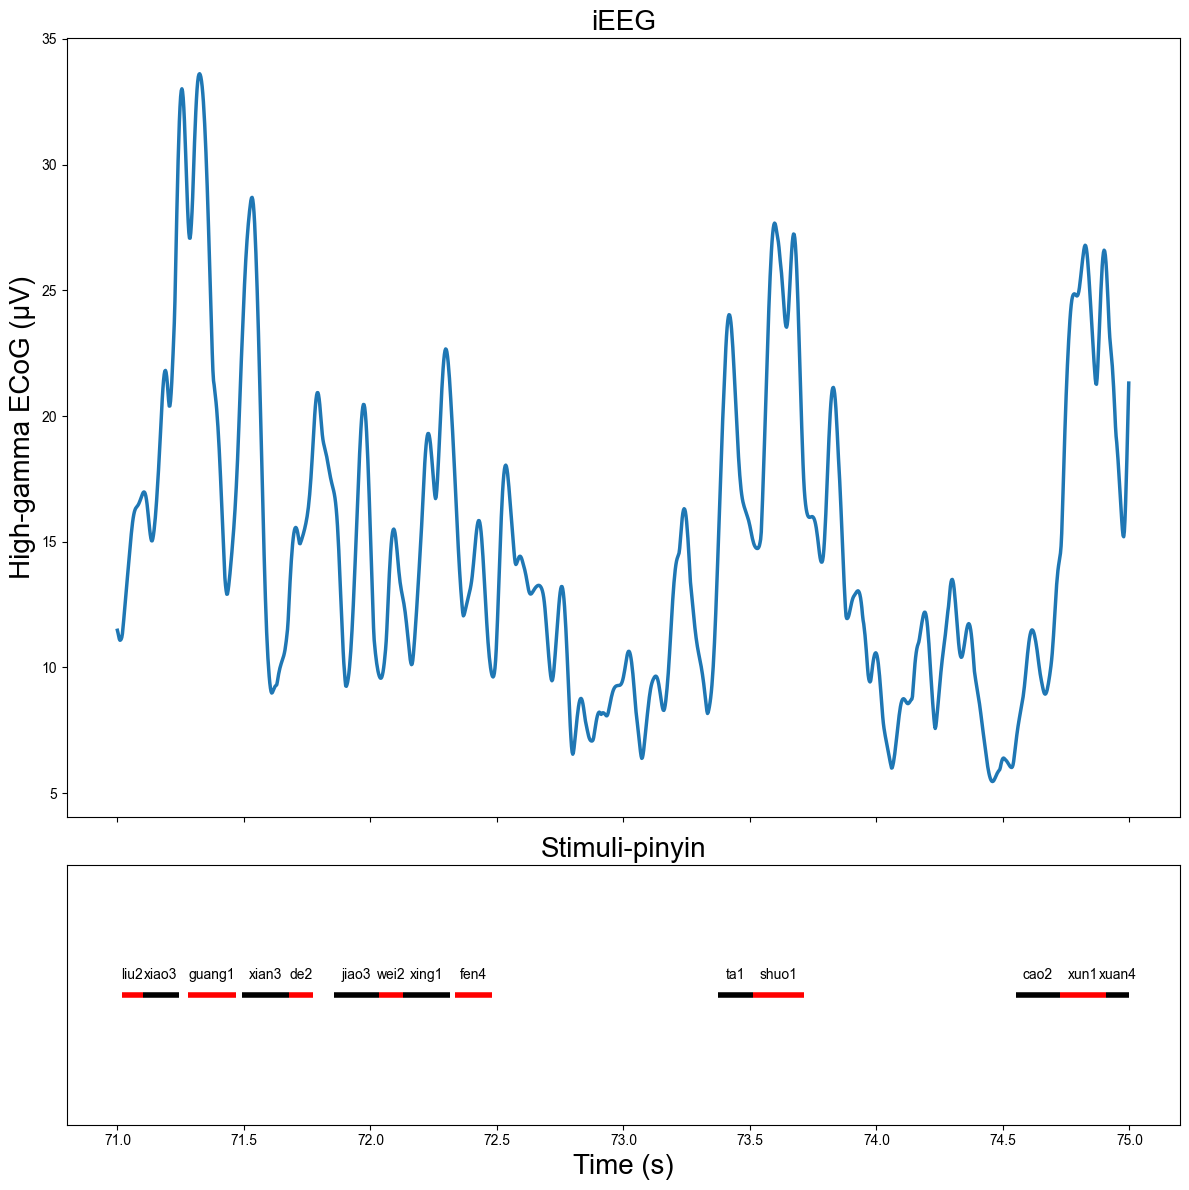

In [3]:
from pynwb import NWBHDF5IO
import numpy as np
import numpy as np
from matplotlib import pyplot as plt
import os

sub = 'sub-01'
session = '01'

with NWBHDF5IO(os.getcwd().rstrip('/code')+f'/{sub}/ieeg/{sub}_task-audio_run-{session}_ieeg.nwb', 'r') as io:
    nwbfile = io.read()

    iEEG_ts = nwbfile.acquisition['iEEG']
    iEEG_data = iEEG_ts.data[:]
    iEEG_sr = iEEG_ts.timestamps[:]
    ECoG = iEEG_data.T

    pinyin_ts = nwbfile.acquisition['Stimuli-pinyin']
    pinyin_data = pinyin_ts.data[:]
    pinyin_sr = pinyin_ts.timestamps[:]

    def plot_ecog_with_stim_one_channel(ecog_data, stim_data, start_time, end_time, channel=0, fs=400):
        plt.rcParams['font.family'] = 'Arial'   # 或者 'Times New Roman' 等
        # plt.rcParams['font.size'] = 14 
        n_channels, n_timepoints = ecog_data.shape

        if channel < 0 or channel >= n_channels:
            raise ValueError("通道号超出范围")
        
        # 时间 -> 索引
        start_idx = int(start_time * fs)
        end_idx = int(end_time * fs)
        if start_idx < 0 or end_idx > n_timepoints:
            raise ValueError("时间范围超出数据范围")
        
        # 截取数据
        time_axis = np.arange(start_idx, end_idx) / fs
        ecog_segment = ecog_data[channel, start_idx:end_idx]
        stim_segment = stim_data[start_idx:end_idx]
        
        # 创建画布
        fig, (ax_ecog, ax_stim) = plt.subplots(2, 1, figsize=(12, 12), sharex=True,
                                            gridspec_kw={'height_ratios': [3, 1]})
        
        # 绘制ECoG波形
        ax_ecog.plot(time_axis, ecog_segment, lw=2.5, color='C0')
        ax_ecog.set_ylabel(f"High-gamma ECoG (μV)", fontsize=20)
        ax_ecog.set_title('iEEG', fontsize=20)
        
        # 颜色设置
        colors = ['#FF0000', '#000000']  # 红 黑
        color_idx = 0
        
        # 绘制刺激信号
        current_stim = stim_segment[0]
        stim_start = start_idx
        for i in range(1, len(stim_segment)):
            if stim_segment[i] != current_stim:
                # 判断是否为空刺激
                if current_stim and str(current_stim).strip():
                    # 有字符串：红黑交替
                    ax_stim.hlines(0, stim_start/fs, (start_idx + i)/fs, colors=colors[color_idx], lw=4)
                    ax_stim.text((stim_start/fs + (start_idx + i)/fs) / 2, 0.1, str(current_stim),
                                ha='center', va='bottom', fontsize=10)
                    color_idx = 1 - color_idx
                else:
                    # 空字符串：白色
                    ax_stim.hlines(0, stim_start/fs, (start_idx + i)/fs, colors='white', lw=4)
                
                current_stim = stim_segment[i]
                stim_start = start_idx + i
        
        # 最后一段
        if current_stim and str(current_stim).strip():
            ax_stim.hlines(0, stim_start/fs, end_time, colors=colors[color_idx], lw=4)
            ax_stim.text((stim_start/fs + end_time) / 2, 0.1, str(current_stim),
                        ha='center', va='bottom', fontsize=10)
        else:
            ax_stim.hlines(0, stim_start/fs, end_time, colors='white', lw=4)
        
        ax_stim.set_ylim(-1, 1)
        ax_stim.set_yticks([])
        ax_stim.set_xlabel("Time (s)", fontsize=20)
        ax_stim.set_title("Stimuli-pinyin", fontsize=20)
        plt.savefig(f"{sub}_session-{session}_ieeg.svg", 
                    format="svg", dpi=300, bbox_inches="tight")
        plt.tight_layout()
        plt.show()

    plot_ecog_with_stim_one_channel(ECoG*10e6, pinyin_data, start_time=71, end_time=75, channel=86, fs=400)